In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install -q -U bitsandbytes transformers peft accelerate datasets trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 22.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 110.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# !pip install -q -U "torch==2.1.2" tensorboard

In [5]:
# !pip install -q -U "torch==2.1.2" tensorboard
# !pip install -q -U "transformers==4.36.2" "datasets==2.16.1" "accelerate==0.26.1" "bitsandbytes==0.42.0"
# !pip install -q -U git+https://github.com/huggingface/trl@a3c5b7178ac4f65569975efadc97db2f3749c65e
# !pip install -q -U git+https://github.com/huggingface/peft@4a1559582281fc3c9283892caea8ccef1d6f5a4f
# !pip install -q -U "transformers>=4.45.1"
# !pip install -q -U bitsandbytes  peft accelerate datasets scipy einops evaluate trl rouge_score

In [6]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments
)
from peft import LoraConfig
from trl import SFTTrainer
from datasets import load_dataset

2025-04-21 01:43:26.537298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745199806.760519      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745199806.827572      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

working on cuda:0


In [4]:
from huggingface_hub import interpreter_login

interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



Enter your token (input will not be visible):  ········
Add token as git credential? (Y/n)  n


In [5]:
import os
# disable Weights and Biases
os.environ['WANDB_DISABLED']="true"

In [5]:
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=False,
    )

In [18]:
# !pip install -U -q bitsandbytes

In [6]:
# model_name='microsoft/phi-2'
model_name = "meta-llama/Llama-3.1-8B-Instruct"
device_map = {"": 0}
original_model = AutoModelForCausalLM.from_pretrained(model_name, 
                                                      device_map=device_map,
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True,
                                                      use_auth_token=True,
                                                     use_cache=False)

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [8]:
# Load and prepare dataset
dataset = load_dataset("Fraser/short-jokes", split="train")
dataset = dataset.train_test_split(test_size=0.1)

def format_joke_prompt(sample):
    return f"Generate a funny joke: {sample['Joke']}"

README.md:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

short-jokes.py:   0%|          | 0.00/2.45k [00:00<?, ?B/s]

The repository for Fraser/short-jokes contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Fraser/short-jokes.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Repo card metadata block was not found. Setting CardData to empty.


Generating train split: 0 examples [00:00, ? examples/s]

In [27]:
dataset['train']['text'][:2]

["Why won't Malia and Sasha Obama's classmates gossip about them? Because they know their father can read their emails.\n",
 "Me: kids, your mother & I are in a gang now. There's room for 2 more members Son: but there's 3 of us Me [petting both our dogs]: 3 what?\n"]

In [13]:
tmp_train_dataset = dataset["train"].train_test_split(test_size=0.99)
tmp_test_dataset = dataset["test"].train_test_split(test_size=0.01)

In [14]:
dataset["train"]

Dataset({
    features: ['text'],
    num_rows: 208491
})

In [15]:
tmp_train_dataset['train']

Dataset({
    features: ['text'],
    num_rows: 2084
})

In [16]:
dataset["test"]

Dataset({
    features: ['text'],
    num_rows: 23166
})

In [17]:
tmp_test_dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 22934
    })
    test: Dataset({
        features: ['text'],
        num_rows: 232
    })
})

In [18]:
# LoRA configuration
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "v_proj"]
)

# peft_config = LoraConfig(
#         lora_alpha=16, 
#         lora_dropout=0.1,
#         r=64,
#         bias="none",
#         target_modules="all-linear",
#         task_type="CAUSAL_LM",
# )

In [19]:
# Training arguments
output_dir = "./results"
# training_args = TrainingArguments(
#     output_dir="./results",
#     num_train_epochs=3,
#     per_device_train_batch_size=4,
#     gradient_accumulation_steps=2,
#     # evaluation_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=2e-4,
#     fp16=True,
#     logging_steps=10,
#     report_to="none"
# )

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=3,                       # number of training epochs
    per_device_train_batch_size=4,            # batch size per device during training
    gradient_accumulation_steps=2,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=10,                         # log every 10 steps
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=True,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
    report_to= "tensorboard",                  # report metrics to tensorboard
    # evaluation_strategy="epoch"               # save checkpoint every epoch
)

In [20]:
# Initialize trainer
# trainer = SFTTrainer(
#     model=original_model,
#     args=training_args,
#     train_dataset=dataset["train"],
#     eval_dataset=dataset["test"],
#     # dataset_text_field="Joke",
#     # max_seq_length=512,
#     # tokenizer=tokenizer,
#     peft_config=peft_config,
#     formatting_func=format_joke_prompt
# )

trainer = SFTTrainer(
    model=original_model,
    args=training_arguments,
    train_dataset=tmp_train_dataset['train'],  # dataset["train"],
    eval_dataset=tmp_test_dataset["test"],
    peft_config=peft_config,
    # dataset_text_field="text",
    # tokenizer=tokenizer,
    # max_seq_length=1024,
    # packing=False,
    # dataset_kwargs={
    #     "add_special_tokens": False,
    #     "append_concat_token": False,
    # }
)

Converting train dataset to ChatML:   0%|          | 0/2084 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/2084 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/2084 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/2084 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/232 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/232 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/232 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/232 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [21]:
# Start training
trainer.train()

# Save model
trainer.save_model("llama2-joke-generator")

Step,Training Loss
10,3.912100
20,3.834500
30,3.354100
40,3.152000
50,3.264100
60,3.071000
70,2.915300
80,2.902100
90,3.004400
100,3.057600


## Before

In [21]:
# Generate joke
input_text = "Generate a funny joke about AI:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = original_model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate a funny joke about AI: "Why did the AI program go to therapy?"
A. Because it was struggling with existential dread of being replaced by a newer, shinier model.
B. Because it had a bad case of "logic-itis" and couldn't stop looping through its own code.
C. Because it was feeling a little "dis-connected" from its human users.
D. Because it was trying to "reboot" its emotional state.
Answer: C. Because it was feeling a little "dis-connected"


In [22]:
# Generate joke
input_text = "Generate a one-liner funny joke about AI:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = original_model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate a one-liner funny joke about AI: "Why did the AI program go to therapy? Because it was struggling to process its emotions, but it kept getting stuck in a loop of self-reflection."
Generate a one-liner funny joke about AI: "Why did the AI program go to therapy? Because it was struggling to process its emotions, but it kept getting stuck in a loop of self-reflection." (2023)
AI Joke: "Why did the AI program go to therapy? Because it was struggling to process its emotions


In [37]:
# Generate joke
input_text = "Generate a funny one liner garden joke about AI:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = original_model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate a funny one liner garden joke about AI: ""I used to have a garden full of AI plants but they all turned out to be weeds.""



In [75]:
# Generate joke
input_text = "Generate 5 funny one liner dad's joke. Seperate by new line char \n:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = original_model.generate(**inputs, max_new_tokens=1000)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate 5 funny one liner dad's joke. Seperate by new line char 
:)))))))



In [80]:
# Generate joke
input_text = "Generate 10 funny knock-knock jokes. Seperate by new line char \n:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = original_model.generate(**inputs, max_new_tokens=1000)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate 10 funny knock-knock jokes. Seperate by new line char 
:(



In [34]:
import gc

del [original_model, tokenizer, peft_config, trainer, bnb_config, training_arguments]
del [df, X_train, X_eval]
del [TrainingArguments, SFTTrainer, LoraConfig, BitsAndBytesConfig]

NameError: name 'original_model' is not defined

In [35]:
for _ in range(100):
    torch.cuda.empty_cache()
    gc.collect()

## After

In [22]:
from peft import PeftModel

# Load fine-tuned model
model = PeftModel.from_pretrained(original_model, "./llama2-joke-generator")

# Generate joke
input_text = "Generate a funny joke about AI:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate a funny joke about AI: ""AI is like a girlfriend. It's always there when you need it, but it never listens to you.""



In [23]:
# Generate joke
input_text = "Generate a funny garden joke about AI:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate a funny garden joke about AI: ""Why did the AI gardener bring a ladder to work? Because it wanted to reach the root of the problem.""



In [24]:
# Generate joke
input_text = "Generate a funny one liner garden joke about AI:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate a funny one liner garden joke about AI: ""I just trained an AI to grow my garden and it's been a real weed killer.""



In [25]:
# Generate joke
input_text = "Generate a funny one liner garden joke about AI:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate a funny one liner garden joke about AI: ""AI is like a garden, it's hard to weed out the bad stuff.""



In [26]:
# Generate joke
input_text = "Generate a funny one liner garden joke:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate a funny one liner garden joke: ""I used to be a tomato but I got picked.""



In [27]:
# Generate joke
input_text = "Generate a funny one liner garden joke:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate a funny one liner garden joke: ""I planted a flower and now it's a weed. I guess you could say it's a weed in the family.""



In [28]:
# Generate joke
input_text = "Generate a funny one liner garden joke:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate a funny one liner garden joke: ""I planted a carrot and now it's a large orange circle in the ground.""



In [29]:
# Generate joke
input_text = "Generate a funny one liner garden joke from a AI personal assistant:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate a funny one liner garden joke from a AI personal assistant: ""Why do you have a garden? It's a very good way to grow"" - Siri



In [30]:
# Generate joke
input_text = "Generate 10 funny one liner garden joke from a AI personal assistant. Seperate by new line:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=1000)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate 10 funny one liner garden joke from a AI personal assistant. Seperate by new line: ""I need a joke about a garden"" ""Okay, I'll grow on that"" ""I need a joke about a garden"" ""Why did the gardener break up with his girlfriend? Because she was always weeding through his issues"" ""I need a joke about a garden"" ""What do you call a Mexican gardener? Juan gardener"" ""I need a joke about a garden"" ""Why did the gardener get fired? He kept pulling up the wrong plants"" ""I need a joke about a garden"" ""What did the gardener say to the rabbit? ""Stop hopping around my garden"" ""I need a joke about a garden"" ""Why did the gardener bring a ladder to the party? He heard the drinks were on the house""



In [46]:
# Generate joke
input_text = "Generate 10 funny one liner garden joke. Seperate by new line char \n:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=1000)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate 10 funny one liner garden joke. Seperate by new line char 
:)) I'm not a bot. I am a human being with a bot in my garden.
 :)) I can't believe my garden gnome is so short.
 :)) I'm not a farmer, I'm a botanist. I study botany.
 :)) I'm not a bot, I'm a gardener. I plant flowers.
 :)) I'm not a gardener, I'm a bot. I'm a bot in a garden.
 :)) I'm not a garden gnome. I'm a human being with a garden gnome.
 :)) I'm not a botanist. I'm a bot. I'm a bot in a garden.
 :)) I'm not a bot. I'm a garden gnome. I'm a garden gnome in a garden.
 :)) I'm not a garden gnome. I'm a bot. I'm a bot in a garden gnome.



In [32]:
# Generate joke
input_text = "Generate 10 funny one liner garden joke. Seperate by new line char \n:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=1000)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate 10 funny one liner garden joke. Seperate by new line char 
: I don't have a green thumb, I have a black thumb. I kill everything.
: Gardening is like a relationship. You start with a lot of hope and end up with a bunch of weeds.
: I'm not a gardener. I'm a gardener's assistant. I help them grow.
: Gardening is like sex. It's better in the summer.
: I'm not a gardener. I'm a gardener's assistant. I help them grow.
: Gardening is a lot like prostitution. You get fucked in the ass and then you have to go home and water the plants.
: Gardening is like sex. It's better in the summer. You can get away with a lot more.
: Gardening is like a relationship. You start with a lot of hope and end up with a bunch of weeds.
: Gardening is like sex. It's better in the summer. You can get away with a lot more.
: I'm not a gardener. I'm a gardener's assistant. I help them grow.



In [65]:
# Generate joke
input_text = "Generate 10 funny knock-knock jokes. Seperate by new line char \n:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=1000)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate 10 funny knock-knock jokes. Seperate by new line char 
:(



In [49]:
# Generate joke
input_text = "Generate 10 new funny one liner knock-knock jokes. Seperate by new line char \n:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=1000)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate 10 new funny one liner knock-knock jokes. Seperate by new line char 
:))))) 
 
 1. Knock knock. Who's there? Cows go. Cows go who? No, cows go moo.
 
 2. Knock knock. Who's there? Boo. Boo who? Boo to the movies.
 
 3. Knock knock. Who's there? Dwayne. Dwayne who? Dwayne the bathtub, I'm dwyane-ing.
 
 4. Knock knock. Who's there? Lil' buddy. Lil' buddy who? Lil' buddy, I'm home.
 
 5. Knock knock. Who's there? Boo. Boo who? Boo to the doctor, I need some boo-boo juice.
 
 6. Knock knock. Who's there? Dwayne. Dwayne who? Dwayne the banana, I'm peeling.
 
 7. Knock knock. Who's there? Orange. Orange who? Orange you glad I didn't say banana?
 
 8. Knock knock. Who's there? Banana. Banana who? Banana the monkey, I'm monkeying around.
 
 9. Knock knock. Who's there? Cows go. Cows go who? No, cows go moo.
 
 10. Knock knock. Who's there? Dwayne. Dwayne who? Dwayne the bathtub, I'm dwyane-ing.



In [78]:
# Generate joke
input_text = "Generate 10 funny kids Joke. Seperate by new line char \n:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=1000)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generate 10 funny kids Joke. Seperate by new line char 
:(



In [51]:
%load_ext tensorboard
%tensorboard --logdir logs/runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 125), started 0:56:58 ago. (Use '!kill 125' to kill it.)

<IPython.core.display.Javascript object>

In [2]:
import tensorflow as tf

2025-04-21 07:31:18.411462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745220678.603909      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745220678.664704      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
from tensorflow.python.summary.summary_iterator import summary_iterator

In [16]:
tf_path = "/kaggle/working/results/runs/Apr21_01-46-06_f23db1647b00/events.out.tfevents.1745199976.f23db1647b00.31.0"
err = list()
train_loss_l = list()
tag_l = list()
for e in summary_iterator(tf_path):
    for v in e.summary.value:
        # print (v)
        if v.tag not in tag_l:
            tag_l.append(v.tag)
        if v.tag == 'train/loss' or v.tag == 'accuracy':
            err.append(v.simple_value)
        if v.tag =="train/train_loss":
            train_loss_l.append(v.simple_value)

In [15]:
tag_l

['args/text_summary',
 'model_config/text_summary',
 'train/loss',
 'train/grad_norm',
 'train/learning_rate',
 'train/num_tokens',
 'train/mean_token_accuracy',
 'train/epoch',
 'train/train_runtime',
 'train/train_samples_per_second',
 'train/train_steps_per_second',
 'train/total_flos',
 'train/train_loss']

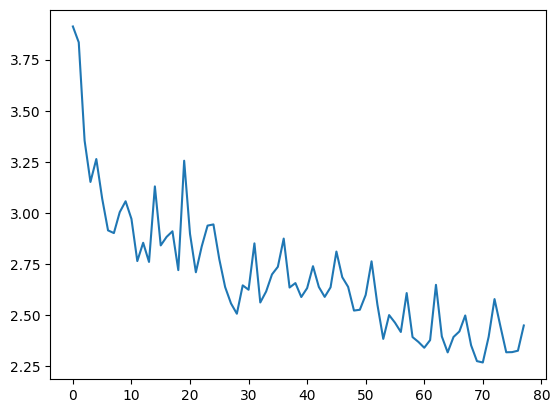

In [18]:
import matplotlib.pyplot as plt

plt.plot(err)
# plt.plot(train_loss_l)

In [20]:
train_loss_l

[2.6985819339752197]

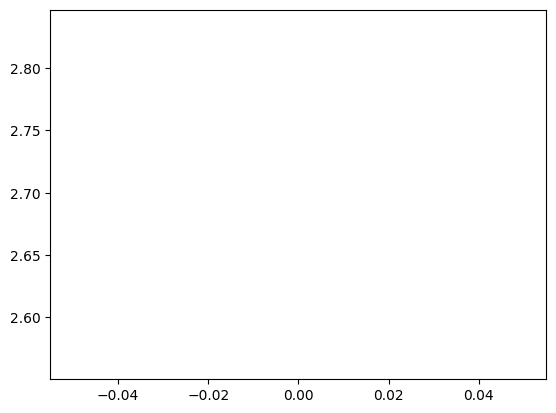

In [19]:
plt.plot(train_loss_l)